In [1]:
import cobra
import pandas as pd
from util.manipulation import load_latest_model
import numpy as np
import matplotlib.pyplot as plt

### Tutorial 2: Applying modifications

In this tutorial, we will perform modifications to the model and observe the resulting predictions. The list of modifications that we will attempt are listed here:

    1- Modify the objective 
    2- Modify the energy demands
    3- Change the model growth media (i.e.: changing the utilized carbohydrate)

In [2]:
#Load the model
model = load_latest_model()
#Changing the objective
#Get the current model objective
from cobra.util.solver import linear_reaction_coefficients
linear_reaction_coefficients(model)

{<Reaction BIOMASS_step3_c at 0x7f4e1b69c1d0>: 1.0}

In [3]:
#The model currently attemtps to optimise biomass production
#We will try to optimize for the production of ATP
#Conveniently a pseudoreaction exists in the model that simply consummes ATP
model.reactions.ATPM

Reaction identifier,ATPM
Name,ATP maintenance requirement
Memory address,0x07f4e1b8be128
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c ATP + H2O --> ADP + H+ + Phosphate
GPR,
Lower bound,15.306122
Upper bound,1000.0


In [4]:
#We will change the objective to this reaction
#First let's set the linear coefficient to 0 for all reactions in the model
for r in model.reactions:
    r.objective_coefficient = 0.

In [6]:
#Verify that this worked
model.optimize()

,fluxes,reduced_costs
AACPS6,0.095716,0.0
ACKr,-10.200000,-0.0
ACPPAT180,0.047858,0.0
ACPS1,0.000000,0.0
ACPpds,0.000000,0.0
...,...,...
G6PDH2r,0.000000,-0.0
GND,0.000000,0.0
TALA,0.000000,0.0
NOX2,10.134848,0.0


In [7]:
#The model solves with an objective value of 0 because no objective was set (kind of a weird mathematical situation)
#Now set the objective to ATPM and solve again
model.reactions.ATPM.objective_coefficient = 1.
#Force a flux through the biomass reaction
model.reactions.BIOMASS_step3_c.lower_bound = 0.59
#Get the optimal ATP production in M.florum
atp_production = model.optimize()
print(f"The model can produce ATP at an optimal rate of {atp_production.objective_value} mmol/gDW/hr")

The model can produce ATP at an optimal rate of 15.445944014005294 mmol/gDW/hr


In [8]:
#Now load the model again to ensure that all modifications are erased
model = load_latest_model()

In [9]:
print(f"The current non-growth associated maintenance cost is {model.reactions.ATPM.lower_bound} mmol/gDW/hr")

The current non-growth associated maintenance cost is 15.306122 mmol/gDW/hr


In [10]:
#We can work with the model in a contextual way to ensure that modifications do not affect our model object
#to do so we use the with statement. This avoids having to load the model again to erase our modifications and may save a lot
#of computing time.
#Let's use this with statement to modify the model's energy demands
ngam = []
with model:
    for i in range(0,15):
        model.reactions.ATPM.lower_bound = i
        #slim_optimize is faster since it only generates the objective value
        ngam.append(model.slim_optimize())

Text(0.5, 0, 'Non-growth associated maintenance')

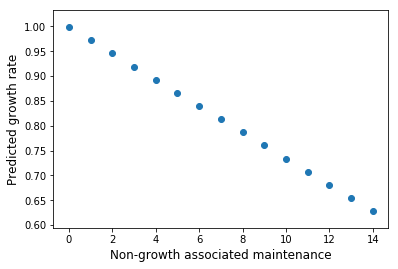

In [14]:
#Plot the growth rate with varying energy demands
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x=range(0,15), y=ngam)
ax.set_ylabel('Predicted growth rate',fontsize=12)
ax.set_xlabel('Non-growth associated maintenance',fontsize=12)

In [15]:
#Let's display the ATPM lower bound to ensure that our with statement worked correctly
#it should be different than 15.0
model.reactions.ATPM.lower_bound

15.306122

In [17]:
#We can change the model medium
#COBRApy provides a function to access the media rapidly
print(f"The model medium contains {len(model.medium)} exchange reactions")

The model medium contains 74 exchange reactions


In [20]:
#Changing the lower bounds on exchange reactions will effectively change to model medium
#We can use that property to determine the essential components in the media
medium_essentiality = []
for r in model.medium:
    with model:
        exchange_rxn = model.reactions.get_by_id(r)
        exchange_rxn.lower_bound = 0.
        medium_essentiality.append({'Exchange_rxn':exchange_rxn.id, 'Solution':model.slim_optimize()})

In [26]:
#Plot the essentiality of model components
medium_essentiality_df = pd.DataFrame(medium_essentiality)
medium_essentiality_df.sort_values('Solution',inplace=True)
medium_essentiality_df.set_index('Exchange_rxn',inplace=True)

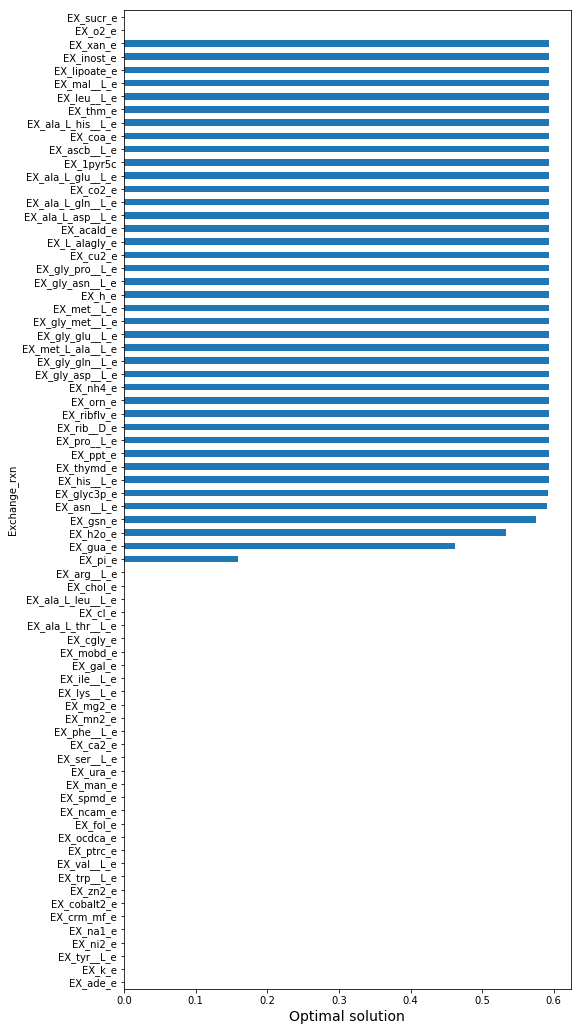

In [35]:
fig = plt.figure(figsize=(8,18))
ax = fig.add_subplot(111)
medium_essentiality_df['Solution'].plot(kind='barh',ax=ax)
ax.set_xlabel('Optimal solution',fontsize=14)
plt.show()

#### End of this tutorial

In this tutorial, dynamic observations were made on the model by modifying some its attributes (energy demands, medium...). Whether or not these predictions are valid is not yet determined as they need to be compared with experimental data. 